# Grocery Website Download Page AB Testing 


**In this use case I am working as an analyst for a large grossery chain. One of the goals our company has, it's to drive more customers to download thier mobile app and register for the loyalty program.**

One of the goals of the company discussed here is to get more users to download the mobile app and sign up for the customer loyalty program.

<p><img src="src/demo.png" alt=""></p>

##### The company is making a link change to a button in the app store and asking if clickthrough rates will increase for the app download page?

## <font color='#d62828'>1- Explain methodology step-by-step foo :</font>

 - ###  <font color='#f77f00'>What data do we have ?</font>

   - IP Address: Client's IP Address
   - LoggedInFlag: Indicates whether the user has a profile on our website
   - ServerID: Belonging to the Treatment and Control group, 1: Treatment , 2-3: Control
   - VisitPageFlag: The status of the user clicking the download link
   
 - ### <font color='#f77f00'> Whats the Duration Of the Test</font> ? 
   - 1 Weak 
   
 - ### <font color='#f77f00'> What's our unit of analysis </font> 
    - IP Address: Client's IP Address 

 - ### <font color='#f77f00'>  What's our metric to measure success ?  </font> 
   - Number of click in download
   
- ### <font color='#f77f00'> The size of our treatment and control groups </font> 
  - 1/3 of the treatment units and 
  - 2/3 of control units.
  
 - ### <font color='#f77f00'>  What's our MDE (Minimum Detectable Effect) ? </font> 
   - MDE 1% 
   
-  ### <font color='#f77f00'> Apply hypothesis testing and check assumptions </font> 
      - Check Normality & Homogeneity
      - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
      - Evaluate the results

In [1]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
import warnings
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Plotting setup
sns.set(style="darkgrid",color_codes=True)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Read Dataset
df = pd.read_csv('grocerywebsiteabtestdata.csv')

In [3]:
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [4]:
# check if is there any null value 
df.isnull().sum()

RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64

### <font color='#f77f00'>  Delete Duplicates </font> 
An Ip address might visit download page multiple times and this can effect our experiment, I reduce the Visit value to 1 for users with multiple visits

In [5]:
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum()

In [6]:
df = df.reset_index(name="VisitPageFlagSum")

In [7]:
len(df['IP Address'].unique())

99516

In [8]:
df = df.drop_duplicates(subset=['IP Address'], keep='first')

In [9]:
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [10]:
# 2/3 of control units.
# 1/3 of the treatment units and

ab_dictionary = {1: "Treatment", 2:"Control", 3:"Control"}
df =  df.replace({'ServerID':ab_dictionary})

###  <font color='#f77f00'> EDA </font>

Control      66287
Treatment    33229
Name: ServerID, dtype: int64
**************************************************


Text(0.5, 1.0, 'Count of each group')

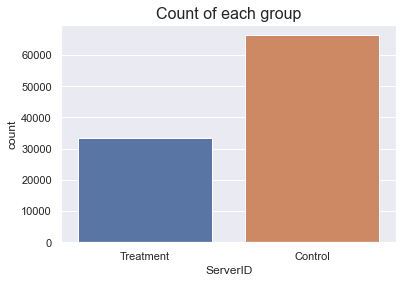

In [36]:
print(df['ServerID'].value_counts())
print("*"*50)

countcluster=sns.countplot(x='ServerID', data=df)
countcluster.set_title('Count of each group',fontsize=16)

0    89538
1     9978
Name: VisitPageFlagSum, dtype: int64
**************************************************


Text(0.5, 1.0, 'Number of VisitPageFlag')

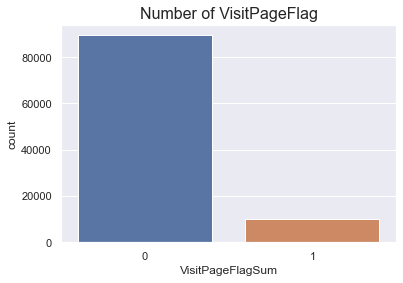

In [38]:
print(df['VisitPageFlagSum'].value_counts())
print('*'*50)
countcluster=sns.countplot(x='VisitPageFlagSum', data=df)
countcluster.set_title('Number of VisitPageFlag',fontsize=16)

In [39]:
# Convert more than 1 VisitPage to 1 
df['VisitPageFlagSum'] = df['VisitPageFlagSum'].apply(lambda x: 1 if x !=0 else 0)

Text(0.5, 1.0, 'Total members of each cluster')

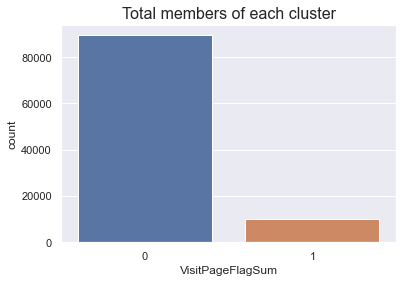

In [15]:
countcluster = sns.countplot(x='VisitPageFlagSum', data=df)
countcluster.set_title('Number of Cleaned VisitPageFlag ',fontsize=16)

In [24]:
df.loc[df['ServerID'] == 'Control']['VisitPageFlagSum'].value_counts(normalize=True)

0   0.9075
1   0.0925
Name: VisitPageFlagSum, dtype: float64

In [27]:
df.loc[df['ServerID'] == 'Treatment']['VisitPageFlagSum'].value_counts(normalize=True)

0   0.8842
1   0.1158
Name: VisitPageFlagSum, dtype: float64

<a id='ab'></a>
## <font color='#f77f00'> A/B Testing</font>

### Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [29]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "Control"][target]
    groupB = dataframe[dataframe[group] == "Treatment"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    
    # "If H0: Normal Distribution"
    if (ntA == False) & (ntB == False): 
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        # "If H0: Homogeneity of variances"
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Put Result into a Dataframe
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })

    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df, group = "ServerID", target = "VisitPageFlagSum")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0000,A/B groups are not similar!


In [33]:
#crosstab by groups

group_count = df.groupby(['ServerID', 'VisitPageFlagSum'])['ServerID'].count().reset_index(name='Count')
groupped = pd.crosstab(group_count['ServerID'], group_count['VisitPageFlagSum'], values=group_count['Count'], aggfunc=np.sum, margins=True)

In [35]:
# get percentage
100*groupped.div(groupped['All'], axis=0)

VisitPageFlagSum,0,1,All
ServerID,,,
Control,90.7508,9.2492,100.0000
Treatment,88.4228,11.5772,100.0000
All,89.9735,10.0265,100.0000


As you can see Control group percentage of users that clicked on the link is **9%** and in the Treatment group is aroud **12%** so we have about **4%** jump.

**The result of our AB test shows that the company can drive approximately about 4% more users to click on the app download if they change the link for the App store / Play store button.**